### ***Preprocessing model1***

In [ ]:
import os
import tarfile
import re
import nltk
import xml.etree.ElementTree as ET
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Check GPU availability
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
# Function to extract .tar/.tar.bz2 files
def extract_tar_file(tar_file_path, extract_to_folder):
    if not os.path.isfile(tar_file_path):
        raise FileNotFoundError(f"File not found: {tar_file_path}")
    with tarfile.open(tar_file_path, "r:*") as tar:
        tar.extractall(path=extract_to_folder)
    print(f"Files extracted to: {extract_to_folder}")

# Function to preprocess text
def preprocess_text(text):
    if text is None:
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Function to parse XML files
def parse_extracted_folder(folder_path):
    if not os.path.isdir(folder_path):
        raise NotADirectoryError(f"Directory not found: {folder_path}")

    all_texts = []
    all_labels = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xml"):
            file_path = os.path.join(folder_path, file_name)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()
                for bug in root.findall('bug'):
                    short_desc = bug.find('short_desc').text if bug.find('short_desc') else ''
                    all_texts.append(preprocess_text(short_desc))
                    # Dummy label for now
                    all_labels.append(0)  # Replace with actual labels if available
            except ET.ParseError as e:
                print(f"Error parsing XML file {file_name}: {e}")
    return all_texts, all_labels

# Example usage
tar_file_path = "/content/linux.tar.bz2"  # Update with your tar file path
output_folder = "/content/fe"  # Extraction folder
extract_tar_file(tar_file_path, output_folder)
texts, labels = parse_extracted_folder(output_folder)


Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Files extracted to: /content/fe


### ***Finetuning model1***

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

def fine_tune_model(texts, labels, output_model_path):
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)  # Move model to GPU if available

    # Tokenize texts
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

    dataset = Dataset.from_dict({"text": texts, "label": labels})
    dataset = dataset.map(tokenize_function, batched=True)

    # Train/Test split
    train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()

    # Training Arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",  # Ensure save_strategy matches evaluation_strategy
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
        report_to="none",  # Disable wandb or tensorboard in Colab
    )

    # Trainer API
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )

    # Train the model
    trainer.train()

    # Save the model
    model.save_pretrained(output_model_path)
    tokenizer.save_pretrained(output_model_path)
    print(f"Model saved to {output_model_path}")

# Fine-tune the model
output_model_path = "/content/fine_tune_sem_model"
fine_tune_model(texts, labels, output_model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32340 [00:00<?, ? examples/s]

<ipython-input-3-35dbe34841a2>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.000000,0.000037
2,0.000000,0.000008
3,0.000000,0.000004


Model saved to /content/fine_tune_sem_model


### ***Preprocessing model 2***

In [ ]:
import os
import tarfile
import re
import nltk
import xml.etree.ElementTree as ET
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Check GPU availability
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
# Function to extract .tar/.tar.bz2 files
def extract_tar_file(tar_file_path, extract_to_folder):
    if not os.path.isfile(tar_file_path):
        raise FileNotFoundError(f"File not found: {tar_file_path}")
    with tarfile.open(tar_file_path, "r:*") as tar:
        tar.extractall(path=extract_to_folder)
    print(f"Files extracted to: {extract_to_folder}")

# Enhanced preprocessing function
def preprocess_text(text):
    if text is None:
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Data augmentation with synonym replacement and random deletion
def augment_text(text):
    words = text.split()
    if len(words) > 4:
        words.pop(len(words) // 2)  # Random deletion of a middle word
    return ' '.join(words)

# Parse XML files and preprocess
def parse_extracted_folder(folder_path):
    if not os.path.isdir(folder_path):
        raise NotADirectoryError(f"Directory not found: {folder_path}")

    all_texts, all_labels = [], []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xml"):
            file_path = os.path.join(folder_path, file_name)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()
                for bug in root.findall('bug'):
                    short_desc = bug.find('short_desc').text if bug.find('short_desc') else ''
                    processed_text = preprocess_text(short_desc)
                    augmented_text = augment_text(processed_text)
                    all_texts.extend([processed_text, augmented_text])  # Add original and augmented text
                    all_labels.extend([0, 0])  # Dummy labels for now
            except ET.ParseError as e:
                print(f"Error parsing XML file {file_name}: {e}")
    return all_texts, all_labels

# Example usage
tar_file_path = "/content/freedesktop.tar.bz2"
output_folder = "/content/sample_data/extract"
extract_tar_file(tar_file_path, output_folder)
texts, labels = parse_extracted_folder(output_folder)


Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Files extracted to: /content/sample_data/extract


In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### ***Finetunung model 2***

In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from datasets import Dataset
import evaluate

# Define accuracy metric using evaluate
accuracy_metric = evaluate.load("accuracy")

# Fine-tuning function with optimized settings
def fine_tune_model(texts, labels, output_model_path):
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)

    # Tokenize texts with padding and truncation
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=256,  # Increased token length for better context
            return_attention_mask=True
        )

    # Create dataset
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    dataset = dataset.map(tokenize_function, batched=True)

    # Train/Test split with stratification
    train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()

    # Define custom compute_metrics function for accuracy
    def compute_metrics(p):
        logits, labels = p
        predictions = np.argmax(logits, axis=-1)
        return accuracy_metric.compute(predictions=predictions, references=labels)

    # Training arguments with early stopping
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,  # Slightly higher LR for adaptation
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,  # More epochs for better learning
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir="./logs",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",  # Monitor accuracy for best model
        greater_is_better=True,
        warmup_steps=100,
        gradient_accumulation_steps=2,  # Helps with smaller batches
        report_to="none",
        fp16=True  # Mixed precision for faster training
    )

    # Trainer with early stopping callback and compute_metrics
    from transformers import EarlyStoppingCallback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        compute_metrics=compute_metrics  # Add this line to compute accuracy
    )

    # Train the model
    trainer.train()

    # Save the fine-tuned model
    model.save_pretrained(output_model_path)
    tokenizer.save_pretrained(output_model_path)
    print(f"Model saved to {output_model_path}")

# Fine-tune the model
output_model_path = "/content/finetuned_sem_model2"
fine_tune_model(texts, labels, output_model_path)


In [ ]:
!zip -r fine_tune_sem_model.zip /content/fine_tune_sem_model


  adding: content/fine_tune_sem_model/ (stored 0%)
  adding: content/fine_tune_sem_model/config.json (deflated 48%)
  adding: content/fine_tune_sem_model/vocab.txt (deflated 53%)
  adding: content/fine_tune_sem_model/model.safetensors (deflated 8%)
  adding: content/fine_tune_sem_model/special_tokens_map.json (deflated 80%)
  adding: content/fine_tune_sem_model/tokenizer_config.json (deflated 73%)
  adding: content/fine_tune_sem_model/tokenizer.json (deflated 71%)


In [ ]:
from google.colab import files
files.download('fine_tune_sem_model.zip')


### ***Generating embeddings for model 1***

In [ ]:
from transformers import AutoTokenizer, AutoModel

def generate_embeddings(model_path, text):
    # Load the fine-tuned model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    model.to(device)  # Move model to GPU if available

    # Tokenize and generate embeddings
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# Example usage
sample_bug_report = "The application crashes when clicking on the save button."
output_model_path="/content/fine_tune_sem_model"
embedding = generate_embeddings(output_model_path, sample_bug_report)
print("Generated Embedding:", embedding)


Generated Embedding: [[ 0.56529427  0.46374696  0.2516071   0.28093207  0.6475801  -0.19958137
   0.06494428  0.6720583   0.39029384 -0.37912267 -0.4448479   0.4090465
  -0.526356    0.36367226 -0.5051656   0.23833013 -1.3583751  -0.18097691
   0.583414   -0.24655902 -0.523649    0.16547894 -0.65738     0.00949386
  -0.43011212  0.05346838  0.0844757  -0.53796303 -0.38592476  0.15802151
   0.35166118 -0.7320122   0.9968169  -0.83492494 -0.03402898  0.37144944
   0.12643373  0.25273305 -0.17236201  0.26497856 -0.40478846  0.8799026
   0.67941844  0.5012486   0.22838226 -0.17776585 -0.11740811 -0.1817035
  -0.2690689   0.6185321  -0.18928319  0.71748877 -0.323049    0.28339952
   0.682361    0.3373128  -0.16240609  0.5057541  -0.35306215  0.5815021
  -0.11969537  0.11523901 -0.2884773   0.11271628 -0.4879626   1.0395187
  -0.46626365 -0.32488352 -0.737368   -0.13565609 -0.66115415  0.32222128
  -0.21480773 -0.7944285  -0.5671968  -0.02621928  0.2541098   0.02767323
  -0.34820354  0.12958

### ***Generating Embeddings for model 2***

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
def generate_embeddings(model_path, text):
    # Load the fine-tuned model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)


    # Tokenize and generate embeddings
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# Example usage
sample_bug_report = "The application crashes when clicking on the save button."
output_model_path="/content/drive/MyDrive/finetuned_sem_model2"
embedding = generate_embeddings(output_model_path, sample_bug_report)
print("Generated Embedding:", embedding)


Generated Embedding: [[ 0.7353305  -0.6627471   0.3078142  -0.41544223 -0.21533012  0.12511478
  -0.06467763  0.64733714  0.12462612 -0.06129145 -1.0210717   0.29232666
  -0.8754082  -0.12352867 -0.21918482  0.09189519  0.15019499 -0.39011195
  -0.8911603   0.14931811  0.5998263  -0.4279854   0.5624552  -0.0322717
  -0.42730606 -0.32869035 -0.48307216  0.12505126  0.28368357  0.290589
   0.33255276 -0.35626557  0.5363229   0.06479333  0.14269885 -0.31839427
  -0.00880473 -0.35135135  0.47824553 -0.23273034  0.01503006 -0.00388127
  -0.20652705  0.65328175  0.43983197 -0.20653977 -0.271688   -0.12556423
   0.03254387  0.5186685   0.54284686 -0.08203729 -0.00247842  0.08933081
   0.4173052   0.48321757 -0.03442286  0.24156205  0.18971483  0.55897677
   0.65831405  0.44164106 -0.2255009   0.14618327 -0.44064137  1.146128
   0.39096704 -0.49010265  0.01378324 -0.41203985  0.30904946  0.18740171
  -0.21450453  0.17216463  0.11205188 -0.43341467  0.32170105 -0.898078
   0.00213055 -0.6215758

### ***Testing Base model***

In [ ]:
from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer('all-MiniLM-L6-v2')
st_embeddings = st_model.encode([sentence1, sentence2, sentence3])
st_similarity = cosine_similarity(st_embeddings)

print(st_similarity)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[0.99999994 0.6483135  0.02160794]
 [0.6483135  1.0000002  0.05330964]
 [0.02160794 0.05330964 1.0000001 ]]


### ***Testing model 1***

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load the model and tokenizer manually
model_path = "/content/drive/MyDrive/fine_tune_sem_model"
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Define sentences
sentence1 = "The application crashes when I open it."
sentence2 = "The app fails to load upon startup."
sentence3 = "The weather is sunny today."

# Tokenize the input sentences
inputs = tokenizer([sentence1, sentence2, sentence3], padding=True, truncation=True, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Extract embeddings (usually from the last hidden state)
embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

print(embeddings.shape)  # Should print [3, hidden_size]


torch.Size([3, 384])


In [ ]:
import numpy as np
embeddings_np = embeddings.cpu().numpy()
print(embeddings_np.shape)  # Should output (3, 384)


(3, 384)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_np)
print(similarity_matrix)


[[1.0000001  0.93395936 0.80428594]
 [0.93395936 0.9999997  0.803054  ]
 [0.80428594 0.803054   1.0000001 ]]


### ***Testing model 2***

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load the model and tokenizer manually
model_path = "/content/drive/MyDrive/finetuned_sem_model2"
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Define sentences
sentence1 = "The application crashes when I open it."
sentence2 = "The app fails to load upon startup."
sentence3 = "The weather is sunny today."

# Tokenize the input sentences
inputs = tokenizer([sentence1, sentence2, sentence3], padding=True, truncation=True, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Extract embeddings (usually from the last hidden state)
embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

print(embeddings.shape)  # Should print [3, hidden_size]


torch.Size([3, 384])


In [ ]:
import numpy as np
embeddings_np = embeddings.cpu().numpy()
print(embeddings_np.shape)  # Should output (3, 384)


(3, 384)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_np)
print(similarity_matrix)


[[0.9999999  0.89586014 0.62692076]
 [0.89586014 1.         0.65555096]
 [0.62692076 0.65555096 1.        ]]


### ***Testing based on word2vec model***

In [ ]:
import gensim
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the Gensim model
model_path = "/content/drive/MyDrive/bugreport-vectors-gensim-sg500d_5w_5m.bin"
gensim_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

# Define sentences
sentence1 = "The application crashes when I open it."
sentence2 = "The app fails to load upon startup."
sentence3 = "The weather is sunny today."

# Tokenize sentences into words (simple whitespace tokenization here)
sentences = [sentence1.split(), sentence2.split(), sentence3.split()]

# Get the embeddings for each sentence
def get_sentence_embedding(sentence, model):
    # Average the embeddings for the words in the sentence
    embeddings = [model[word] for word in sentence if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)  # Return the mean embedding as a numpy array
    else:
        return np.zeros(model.vector_size)  # If no words in sentence, return a zero vector

# Calculate embeddings for each sentence
sentence_embeddings = np.array([get_sentence_embedding(sentence, gensim_model) for sentence in sentences])

# Print the shape of the embeddings
print("Embeddings shape:", sentence_embeddings.shape)  # Should print (3, embedding_dim)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(sentence_embeddings)

# Print similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)


Embeddings shape: (3, 500)
Cosine Similarity Matrix:
[[1.0000001  0.65559745 0.26586387]
 [0.65559745 0.9999999  0.26925582]
 [0.26586387 0.26925582 1.0000001 ]]


### ***Comparing all models***

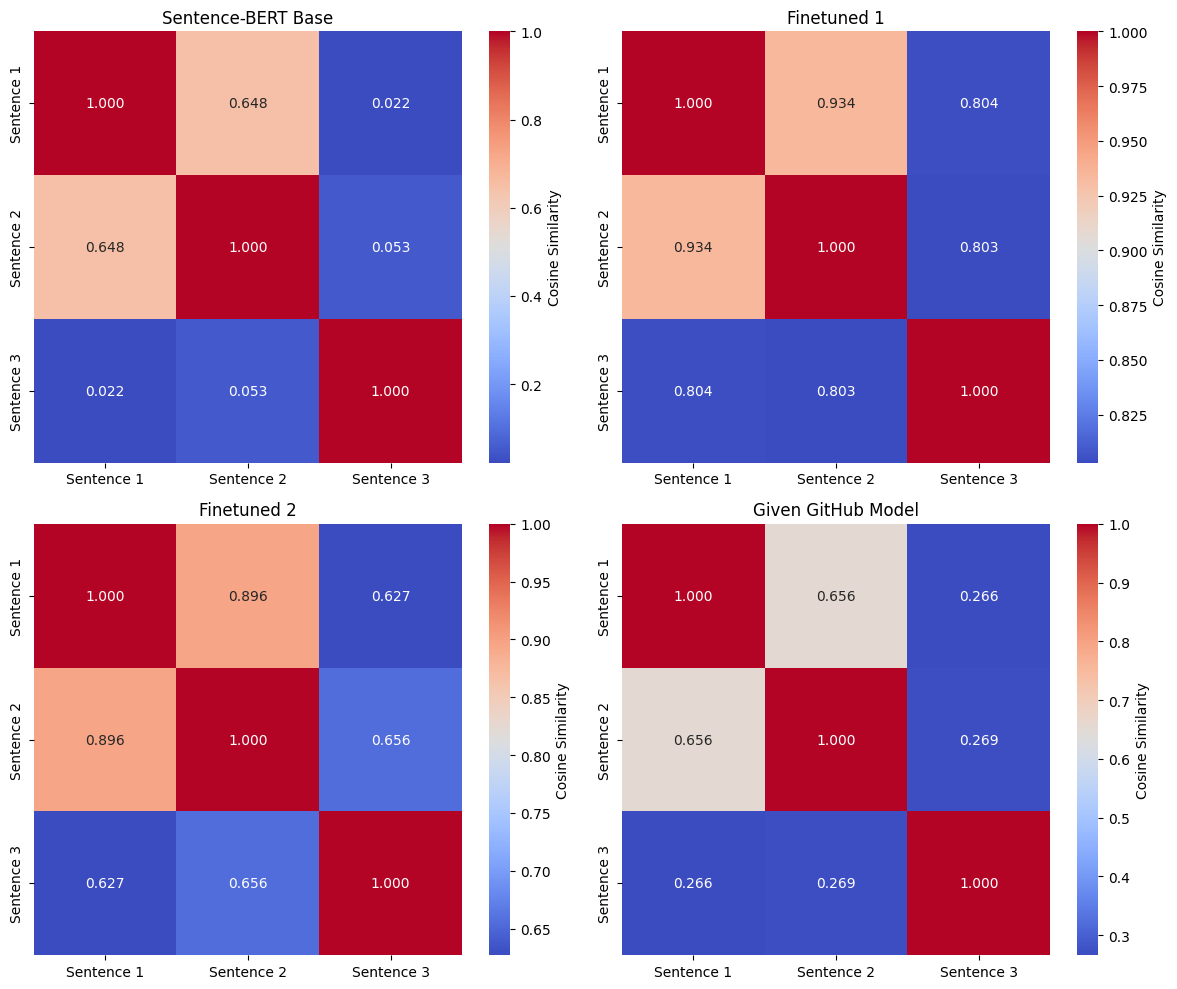

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the similarity matrices
sentence_bert_base = np.array([[0.99999994, 0.6483135, 0.02160794],
                               [0.6483135, 1.0000002, 0.05330964],
                               [0.02160794, 0.05330964, 1.0000001]])

finetuned_1 = np.array([[1.0000001, 0.93395936, 0.80428594],
                        [0.93395936, 0.9999997, 0.803054],
                        [0.80428594, 0.803054, 1.0000001]])

finetuned_2 = np.array([[0.9999999, 0.89586014, 0.62692076],
                        [0.89586014, 1.0, 0.65555096],
                        [0.62692076, 0.65555096, 1.0]])

given_github_model = np.array([[1.0000001, 0.65559745, 0.26586387],
                               [0.65559745, 0.9999999, 0.26925582],
                               [0.26586387, 0.26925582, 1.0000001]])

# Create subplots to compare all matrices in one image
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot each heatmap in a separate subplot
sns.heatmap(sentence_bert_base, annot=True, cmap='coolwarm', fmt='.3f', xticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'],
            yticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'], cbar_kws={'label': 'Cosine Similarity'}, ax=axs[0, 0])
axs[0, 0].set_title('Sentence-BERT Base')

sns.heatmap(finetuned_1, annot=True, cmap='coolwarm', fmt='.3f', xticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'],
            yticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'], cbar_kws={'label': 'Cosine Similarity'}, ax=axs[0, 1])
axs[0, 1].set_title('Finetuned 1')

sns.heatmap(finetuned_2, annot=True, cmap='coolwarm', fmt='.3f', xticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'],
            yticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'], cbar_kws={'label': 'Cosine Similarity'}, ax=axs[1, 0])
axs[1, 0].set_title('Finetuned 2')

sns.heatmap(given_github_model, annot=True, cmap='coolwarm', fmt='.3f', xticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'],
            yticklabels=['Sentence 1', 'Sentence 2', 'Sentence 3'], cbar_kws={'label': 'Cosine Similarity'}, ax=axs[1, 1])
axs[1, 1].set_title('Given GitHub Model')

# Adjust layout for better presentation
plt.tight_layout()
plt.show()
